<a href="https://colab.research.google.com/github/EdmilsonSantana/llm-vehicle-repair/blob/main/Assistente_do_Mecanico_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
%%capture
%pip install selenium beautifulsoup4 datasets transformers[torch] deep-translator

## Scraping data from AutoZone

We are going to extract the content from the articles found in AutoZone sitemap and finetune the Flan-T5 model.

In [1]:
from articles import extract_articles
import pandas as pd

In [2]:
data_dir = './data'

In [3]:
articles = extract_articles(data_dir)

In [4]:
print(articles[0])

{'title': 'Car AC Blowing Hot Air', 'content': "Understanding the Causes\n\nA quick understanding of how air conditioning works can help with understanding what the causes could be. When AC is turned on, refrigerant that flows through the system absorbs heat from your vehicle's cabin where it's removed and, through a series of parts and processes, the heat is released into the atmosphere before circulating back and repeating the process. There are several points where something can be wrong, causing warm air rather than cool:\n\nThere isn't sufficient airflow in the cabin. This could be a problem with a bad blower motor, but more commonly a plugged cabin air filter is the culprit.\nThere isn't enough refrigerant. The gas that circulates through the system can leak out, preventing it from working efficiently.\nThe compressor may not be cycling. A clutch issue or a compressor failure can prevent the AC system from being able to disperse the heat the refrigerant has absorbed.\nThe expansi

In [5]:
faq_questions = []
for article in articles:
    faq_questions.extend(article['faq_questions'])

In [6]:
df_faq = pd.DataFrame(faq_questions)

In [7]:
has_autozone_text = df_faq['question'].str.contains('AutoZone')
df_faq.drop(index=df_faq[has_autozone_text].index, inplace=True)

In [8]:
df_faq.head()

,question,answer
0,Why is my car AC blowing hot air?,There could be a multitude of root causes with...
1,Can I fix a hot AC issue myself?,There are some issues that can be done on your...
2,What are the signs of a failing AC compressor?,"Clunking noises when the compressor cycles, in..."
3,How often should I service my car's AC system?,"Annually, check that your AC is working proper..."
4,When should I consider professional help for m...,If DIY solutions haven't fixed the problem or ...


In [9]:
df_faq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1769 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1769 non-null   object
 1   answer    1769 non-null   object
dtypes: object(2)
memory usage: 41.5+ KB


## Fine-Tuning Flan T5 Model

In [10]:
%%bash
pip install nltk
pip install datasets
pip install transformers[torch]
pip install tokenizers
pip install evaluate
pip install rouge_score
pip install sentencepiece
pip install huggingface_hub

In [11]:
import nltk
import evaluate
import numpy as np
from datasets import load_dataset, Dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from articles import extract_articles
import pandas as pd

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/utils/generic.py:462: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/utils/generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
# Load the tokenizer, model, and data collator
MODEL_NAME = "google/flan-t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
dataset = Dataset.from_pandas(df_faq)
train_test_ds = dataset.train_test_split(test_size=0.2)
# We prefix our tasks with "answer the question"
prefix = "Please answer this question: "

In [14]:
train_test_ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 1415
    })
    test: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 354
    })
})

In [15]:
# Define the preprocessing function

def preprocess_function(examples):
   """Add prefix to the sentences, tokenize the text, and set the labels"""
   # The "inputs" are the tokenized answer:
   inputs = [prefix + doc for doc in examples["question"]]
   model_inputs = tokenizer(inputs, max_length=128, truncation=True)
  
   # The "labels" are the tokenized outputs:
   labels = tokenizer(text_target=examples["answer"], 
                      max_length=512,         
                      truncation=True)

   model_inputs["labels"] = labels["input_ids"]
   return model_inputs

# Map the preprocessing function across our dataset
tokenized_dataset = train_test_ds.map(preprocess_function, batched=True)


Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

In [16]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1415
    })
    test: Dataset({
        features: ['question', 'answer', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 354
    })
})

In [17]:
nltk.download("punkt")
metric = evaluate.load("rouge")

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
def compute_metrics(eval_preds):
   preds, labels = eval_preds

   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

   result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  
   return result

In [19]:
# Global Parameters
L_RATE = 3e-4
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 4
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 10

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   learning_rate=L_RATE,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   num_train_epochs=NUM_EPOCHS,
   predict_with_generate=True,
   push_to_hub=False
)

In [20]:
trainer = Seq2SeqTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,2.149851,0.325831,0.135755,0.264907,0.270366
2,No log,2.093176,0.325019,0.133975,0.263560,0.270240
3,2.070600,2.108422,0.320579,0.137358,0.262536,0.268787
4,2.070600,2.157729,0.329891,0.145051,0.272676,0.278419
5,2.070600,2.221337,0.324979,0.140882,0.266297,0.271246
6,1.278700,2.276956,0.324359,0.140910,0.266741,0.271738
7,1.278700,2.402885,0.326588,0.143634,0.269227,0.275727
8,1.278700,2.450764,0.327633,0.144797,0.267569,0.274056
9,0.897400,2.572177,0.322558,0.139045,0.264247,0.270081
10,0.897400,2.615739,0.328173,0.144781,0.268941,0.274802


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transf

TrainOutput(global_step=1770, training_loss=1.314621032025181, metrics={'train_runtime': 592.9578, 'train_samples_per_second': 23.863, 'train_steps_per_second': 2.985, 'total_flos': 443392422460416.0, 'train_loss': 1.314621032025181, 'epoch': 10.0})

In [30]:
last_checkpoint = "./results/checkpoint-1500"

finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
my_question = "What are the disadvantages of synthetic blend oil?"
inputs = "Please answer to this question: " + my_question

inputs = tokenizer(inputs, return_tensors="pt")
outputs = finetuned_model.generate(**inputs)
answer = tokenizer.decode(outputs[0])
from textwrap import fill

print(fill(answer, width=80))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<pad>Synthetic blend is more expensive than conventional oil, and it's less durable than conventional oil


## Scraping "O Mecânico"

In [1]:
! pip install seaborn

In [2]:
from mecanico import extract_posts
import pandas as pdimport
from nltk import tokenize

In [3]:
posts = extract_posts()


In [4]:
sentences = []
for post in posts:
    sentences.extend(post['sentences'])

In [5]:
sentences[20:30]

['15) Com um pano, remova o excesso de graxa.',
 '16) Localize a trava externa da junta homocinética.',
 '17) Com o auxílio de um alicate, solte a trava da junta homocinética.',
 '18) Retire a junta homocinética e a coifa antiga.',
 '19) Limpe o semieixo e faça uma verificação do estado das estrias e do canal da trava da homocinética.',
 '20) Neste Chevrolet Celta 2011 foi utilizado o kit VKJA 41000 A, da SKF, que já inclui a homocinética fixa com porca, coifa, abraçadeiras, graxa de bissulfeto de molibdênio e manual de montagem. Utilize todos os novos componentes do kit.',
 '21) Antes de iniciar a montagem da nova homocinética, proteja a extremidade do semieixo com uma fita a fim de evitar rasgos causados pelas estrias no momento da instalação da coifa.',
 '22) Instale a nova coifa no semieixo e retira a fita utilizada para proteção.',
 '23) Faça a lubrificação da junta homocinética com a graxa de bissulfeto de molibdênio.',
 '24) Introduza a junta homocinética no semieixo, observando

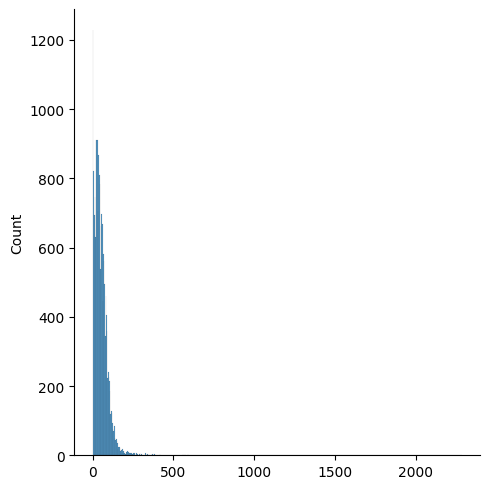

In [6]:
import seaborn as sns
import numpy as np

sentences_lengths = []

for sentence in sentences:
    tokens = tokenize.word_tokenize(sentence)
    sentences_lengths.append(len(tokens))

sentences_lengths = np.array(sentences_lengths)

sns.displot(sentences_lengths)

In [7]:
len(sentences_lengths[sentences_lengths > 1024])/len(sentences_lengths)

0.0014411529223378704

In [8]:
np.average(sentences_lengths)

55.60432345876701

## Fine-Tuning GPT-2

https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=63t_69HjlwAj

https://tuanatran.medium.com/fine-tuning-large-language-model-with-hugging-face-pytorch-adce80dce2ad

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup


In [25]:
tokenizer = GPT2Tokenizer.from_pretrained('pierreguillou/gpt2-small-portuguese', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')
tokenizer.model_max_length=1024

In [26]:
print("The max model length is {} for this model, although the actual embedding size for GPT PT-BR small is 1024".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT PT-BR small is 1024
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 0
The padding token <|pad|> has the id 50258


In [27]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=1024):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [28]:
dataset = GPT2Dataset(sentences, tokenizer, max_length=1024)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,861 training samples
1,874 validation samples


In [29]:
batch_size = 2
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [30]:
# instantiate the model
model = GPT2LMHeadModel.from_pretrained("pierreguillou/gpt2-small-portuguese")

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [31]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [32]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [34]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [35]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  8,431. Loss: 0.15877652168273926.   Elapsed: 0:00:23.
0: Grupo. do disco os destaques são os componentes elétricos e o sistema de limpeza, que pode ser indicado com o equipamento mecânico instalado. O disco é polidos no padrão de 2400 L (13.7V). Além de não ter problema com o desgaste do disco pode ser utilizado a troca de combustível, pois é recomendado ao uso de motor diesel. Além disso as especificações para o disco são idênticas àquelas para o sistema eletrônico e com os componentes elétricos o disco é com uma potência máxima de 150 cv (59 cv de potência, 5.2 V) com potência de 100 cv (16 cv, 5.8 V), com câmbio automático manual, de 3 marchas e câmbio manual, com comando manual (15-T) (5 marchas), câmbio automático e freios ABS. O disco é feito em linha de montagem do, com injeção eletrônica, de combustível líquido de 5 litros (2 T), de 0.5 T de Nitro de Na (7.0 N),


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  8,431. Loss: 0.15369173884391785.   Elapsed: 0:00:49.
0: tário e a sua localização na estrada. Após ter sido retirada na sua volta, passou o teste do veículo (16/12/2018) de apoio que ficou sem problema. (ADMU) é o sistema de freio automático do veículo que determina a posição do cilindro. É utilizado para o aumento do câmbio dianteiro e de troca. O sistema está indicado por uma chave de ignição e é utilizado na carcaça, quando as válvulas estão em funcionamento. O modelo 1D de 70 mm (18 mm atrás do cilindro) está indicado. Esse sistema está indicado no veículo (18 mm atrás do cilindro). O motor do carro possui as marchas em marcha constante (12v) e câmbio automático, a indicação é 12 CV. Quando o combustível está em aplique, a válvula também é acionado, quando possui a chave de ignição. Essa chave também é utilizada nas trocas e na transmissão (18 mm atrás do cilindro) na transmissão (18 mm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  8,431. Loss: 0.2308550328016281.   Elapsed: 0:01:14.
0: nos do sistema, com o qual a chave do módulo de comando é o mesmo da chave da cabine. é um sistema elétrico, desenvolvido pela unidade de transporte de ônibus de todo o Brasil para ônibus de carga em ônibus urbano. Com o auxílio do veículo de alta performance ônibus, a diferença na utilização de combustível e nas condições de uso entre os veículos é de 40% (54) a 40% (30) do custo do veículo de carga. O sistema é dotado de três baterias, a saber: um por cilindro, um por cilindro e um por cilindro de dupla plaqueta.
O sistema vem sendo utilizado desde meados do século XX pelos ônibus que realizam a manutenção de ônibus, tanto para ônibus de carga quanto para ônibus urbano. O ônibus do tipo ônibus urbano também vem sendo usados na manutenção de outros veículos, como ônibus de ônibus diesel, ônibus urbano e ônibus de ônibus ABS. O sistema foi desenvolvido na própria linha da ônibus ônibus da Fiat entre 2003 e 2005,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  8,431. Loss: 0.39087721705436707.   Elapsed: 0:01:39.
0:  along, é uma cidade da região do vale do Rio das Bocas, localizada entre a cidade de São Bernardo de Campo a São Bernardo do Campo, e São Bernardo do Campo-SP. Também conhecida como Porto Alegre ou Porto Alegre, é uma cidade com um pouco mais de 30 anos de história, sendo que já estão entre os mais importantes pólos do estado e também um dos mais importantes centros de serviços de qualidade do Brasil. Entre as muitas funções de direção do sistema de arrefecimento e da bomba d’água, Porto Alegre possui a responsabilidade das respectivas unidades elétricas e de sistema de transmissão de óleo, com um papel cada vez mais importantes. Vale ressaltar que o sistema de troca de óleo é a base do sistema de troca de óleo-pirólise aplicado no sistema hidráulico do motor. é um modelo do tipo Peugeot Eaton, utilizado na marca da Honda. Ele foi o primeiro veículo da Honda a ter um câmbio interno no mercado na versão


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  8,431. Loss: 0.45087066292762756.   Elapsed: 0:02:04.
0: •: Soldas/2-3
Drive 8000 vezes no máximo. A Naisulis do – Sone, A reportagem da reportagem tem como ponto de referência os pontos de referência para este processo na produção de um líquido refrigerante. (OUT) – Com 13 anos de história e 12 prêmios, esta cidade do México possui a quinta posição da IUMOM e ainda em primeiro. Na comparação, o Brasil ocupa primeiro lugar, atrás de São Paulo (11º lugar entre os principais). A cidade tem uma economia, é bem formada com vários tipos de serviços: o sistema de energia, o papel de serviços não-utilizados no


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  8,431. Loss: 0.11235810071229935.   Elapsed: 0:02:29.
0:  blocoO mecânico não é o único a prestar serviço aos clientes do carro. Antes da instalação do sensor de ABS, os veículos da cidade de São Paulo já tinham problemas com sua vida útil. O filtro não possui filtros para a corrente de baixa pressão, que é responsável pela perda de vida de combustível. São os filtros que o veículo utiliza. Antes de instalação, é preciso tomar cuidado com o fluxo de ar do filtro e verificar que a sua aplicação é normal, o que permite que ele não seja interrompida. “O filtro tem o objetivo de não agredir o motor e provocar acidentes”, alerta o gerente Comercial da Bosch Automotive Co. O filtro é responsável pelo abastecimento do fluido de poluentes do ar e também, é responsável por o balanço de potência de baixa pressão da bomba de ar. mangueiras do


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  8,431. Loss: 0.4397437274456024.   Elapsed: 0:02:54.
0: 89 de entrada do sistema. Neste caso a pressão ocorre na entrada, enquanto os resíduos do sistema são filtradores. é um serviço de alta tecnologia da Shell que recebe, em média, 1,030 MW, capaz de entregar a emissão de alta potência do motor, com potência de 240 cv, ou 4 kgfm ou 5,0 kgfm de torque máximo máximo máximo que seja a potência obtida por motor. Por fim, o programa possui fácil substituição de componentes, já que o motor está sujeito à sua revisão sem a correção por meio da recomendação de diagnóstico do profissional. “O veículo é dividido em uma unidade de injeção de combustível e um motor-leve e tem em sua bancada a caixa de transferência da bomba de alta pressão”, comenta Alexandre Vilmar de A. KYBB.  Ele também alerta sobre a possibilidade de não-conversação no comando do motor quando a correia hidráulica de freio


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  8,431. Loss: 0.23727595806121826.   Elapsed: 0:03:19.
0: isc: “o mecânico não pode retirar o conjunto, mas o carro sempre está funcionando, sempre no elevador de alta velocidade e é legal que a tubulação esteja no seu acesso. “É bom lembrar que o carro está em uso no momento do funcionamento normal, ou seja, uma vez que o motor está parado e a potência e a potência estão totalmente na mesma. Mas se você remover a tubulação, o motor pode não funcionar até a bomba d’água, se você não reinstalar o conjunto e o carro será parada. O carro estava totalmente parado, só há a possibilidade de ele parar ou pegar numa bateria. Se ele ficar parado e o carro vai parar em seguida a bomba d’água vai dar continuidade, já que o motor está totalmente funcionando. Ele sempre está, mas o carro já estava parado”. Se a bomba d’água não for removido, pode causar perda de potência.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  8,431. Loss: 0.41053807735443115.   Elapsed: 0:03:44.
0:  negociadoCom os amortecedores nas ruas, foram incorporadas os conjuntos de amortecedores convencionais. A manutenção em estradas de estradas fechadas é uma grande importância, já que em caso de uso severo, pode danificar o cabeçote da torre de suspensão, possibilitando ao amortecedor a perder sua posição. Para não forçar a torre de suspensão, basta fazer uma inspeção.  Traque o tensionador de freio, que é instalado em um volante para atestar se é necessário remover o tensionador do freio.   É importante lembrar que a peça deve ter sido aplicada em todas as suas etapas, não só no centro, mas em todas as faces do veículo. (A.M.C) é um mecânico mecânico de componentes do Brasil e proprietário de uma oficina de montagem que fabrica cerca de 30 produtos no mercado internacional, dos quais cerca de 1,8 mil são fabricados pela Bosch. A montagem segue a linha da Ford (R7)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  8,431. Loss: 0.10827979445457458.   Elapsed: 0:04:09.
0:  práticaA montagem segue os mesmos padrão da suspensão dianteira, por isso, as peças são de fácil reparabilidade. O tensionador é acionado por uma chave combinada 17 mm (1,5 mm do primeiro cilindro) e o coletor de admissão já vem alinhado. A correia está de um comprimento de 15 mm com uma função de regulagem da bomba de escape para atender o torque de aperto, que é de 6,2 Nm (1,5 a 5,4 mm de torque). (SKD) é um serviço de informações e informações a base de informações relacionados ao veículo e à linha de veículos, através do fabricante e pela fabricante de produtos, na América do Sul. Seu proprietário fica localizado no Valeo, em Valinhos- RJ. O catálogo de produtos do serviço é baseado nos mapas de manutenção do Peugeot 206 e Citroën C3 S10. (28 de junho de 2007) é um técnico de


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  8,431. Loss: 0.2522244155406952.   Elapsed: 0:04:34.
0:  QuirImotivo de ar, ou ar condicionado, também conhecido como ar do motor, está localizado no cabeçote superior dos pneus, no compartimento do reservatório, no compartimento de apoio para o motor, com caixa de câmbio, sistema ABS, e motor embreagem. Sua função é garantir a estabilidade e o funcionamento de todo o conjunto, independentemente de um veículo ou veículo em estrada urbano. O funcionamento do sistema é feito a cada 20 mil quilômetros. da Revista O Mecânico teve um acidente no trânsito rodoviário nacional em pleno trânsito e foi possível observar um pequeno incidente com trânsito urbano em todo o país e, consequentemente, com o veículo. Porém, o acidente nem sempre foi um problema crônicos que nem sempre foi aparente. Porém, os problemas de trânsito podem existir na parte traseira do veículo, no lado esquerdo do veículo (no lado direito da traseira do acelerador), em outros carros e em ruas, como a pica

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  8,431. Loss: 0.43338391184806824.   Elapsed: 0:04:59.
0:  Foster8) Inicie a torre de suspensão do motor para ter acesso ao bloco: a montagem do bloco deve ser feita por diversos fatores. Por isso, o principal que deve ser feito é um sistema mais simples com mais facilidade para manutenção e com maior durabilidade. Se o bloco for removido dentro da instalação de manutenção, o motor precisará de ferramentas especiais para a desmontagem e manutenção correto. Na mesma hora, utilize uma chave Allen de emergência., que é o coordenador de treinamento do programa de treinamento do Instituto Ford, em Valinhos, SP, levou o evento para a imprensa, onde o proprietário do sistema de sincronismo da empresa levou a seguinte observação: “É imperativo ter acesso aos componentes que podem facilitar o desempenho de um carro no trânsito urbano”, afirma. (5 de junho de 2013) é uma das sondas mais antigas que já foram aprovadas por uma grande imprensa do setor com foco em auxiliar a mante

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  8,431. Loss: 0.06648953258991241.   Elapsed: 0:05:24.
0:  Santíssimo.   Brasil Brasil | Brasil | Al Brasil | Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | Al Brasil | E, T, E,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  8,431. Loss: 0.20496244728565216.   Elapsed: 0:05:49.
0:  repleAcompanhe agora os modelos: Volkswagen Spin Pack, Volkswagen TRO, Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller Troller


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  8,431. Loss: 0.3214110732078552.   Elapsed: 0:06:14.
0:  aband7- Remova o sincronizador e retire o óleo, que é fixado com trava. O óleo foi fabricado com fábrica italiana, o motor E.torQ2001-B, que segue a mesmas regra de manutenção do motor E.torQ2001-B (3). Aspecto: 8606907 O Mecânico O Mecânico  Communal   Aspecto: 86069077, Aspecto: 8606907, 2017, teve o desempenho melhor do modelo desde a estreia dos motores do Gol, com 2.200cv a menos em relação a outros motores da Ford. Por baixo, as versões de 8606907 de fábrica são quatro cilindros.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  8,431. Loss: 0.04926364868879318.   Elapsed: 0:06:39.
0:  Borgonha– Solte os parafusos de fixação da correia dentada e a junta de fixação da junta de fixação da junta com um martelo., conhecido popularmente como “Zóleo do virabrequim”, está localizado na região do coletor de escapamento. Faz a saída da turbina e os terminais da conexão com o filtro de ar de admissão. Por cima, a bateria fica localizada., conhecido popularmente como “Zóleo do virabrequim”, está localizado na região do coletor de escapamento. Por cima, a bateria fica localizada., conhecido popularmente como “Zóleo do virabrequim” é um item muito popular entre o mecânico e o mecânico profissional. O item é um utilitário de série, mas sem perder o ponto., conhecido popularmente como “Zóleo do virabrequim”, está localizado em um local


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  8,431. Loss: 0.39272335171699524.   Elapsed: 0:07:04.
0:  ModNa montagem, não se esquecer de engatar uma sonda lambda de alta pressão para que a sonda lambda possa ser trocada, com o auxílio de um martelo para soltá-la. Lembre-se que o torque final da peça é de 55.750 rpm e o torque final da sonda lambda estará em torno de 50.000 rpm. Neste caso, observe o torque final do parafuso de cabeça para baixo: de 50.000 rpm e em torno de 60.000 rpm. Depois, utilize uma chave L12 mm para soltar a sonda. Na montagem, o torque final da sonda lambda é de 27.000 rpm e a mesma foi trocada com o auxílio de um martelo. com injeção por ar (COMO: 4.5) com capacidade para receber 6.000 (COMO: 35)itro de potência, com fácil acesso à fixação do suporte de sustentação. A injeção é automática de três estágios


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  8,431. Loss: 0.19349679350852966.   Elapsed: 0:07:29.
0: cos6. A primeira etapa de montagem da peça é na seqüência: Todo este conjunto é construído por profissionais da Michelin em parceria com a General Motors, e sua oficina é ligada ao mecânico, responsável por manter o nível de óleo e temperatura do fluido de freio da sua oficina. “Quando o motor estiver no chão com a roda suspensa, o turbo é o responsável pela manutenção do sistema hidráulico e, se estiver suspenso e não estiver mais, o turbo é o responsável pelo diagnóstico dos componentes do sistema de alta pressão. O turbo tem que ser acionado por parte dacionar­ção do motor com o pedal parado e o turbo, que é o último componente, não é capaz de manter a eficiência do seu movimento, fazendo com que o carro se coloque o óleo. O mecânico pode escolher um outro, dependendo da condição de uso”, alerta.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  8,431. Loss: 0.27877697348594666.   Elapsed: 0:07:54.
0: êm13) Remova os parafusos de fixação da correia elástica que fixam a correia por fixado no cavalete, utilizando a chave L 13 mm (13a). Remova o tensionador de fixação do virabrequim, que é para cima (13b). Depois, remova a correia elástica do lado direito e aperte o parafuso de fixação do parafuso. (22) (45) Com o auxílio de Gustavo Lalli, o painel de confirmação dos modelos com as sondas lambdas do INS, assim como o procedimento completo de substituição dos componentes do veículo, é considerado o momento certo da substituição. (19) e o painel de fotos de Marcelo Caretta a ser seguido foram apresentados nas apresentação do painel. Depois de analisar a estrutura dos veículos, Roberto Santos, diretor de Novos Negócios da ZF, e André Haddad, consultor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  8,431. Loss: 0.20327818393707275.   Elapsed: 0:08:19.
0: anças6. Com o conjunto do conjunto, aplique uma medida na sequência e faça o ajuste correto pelo circuito de alimentação da correia. O circuito vai para o coletor, próximo à polia, gerando uma medida na medição da tensão do coletor, evitando que ele fique cheio ou com nenhuma tensão. A tensão do coletor deve ser fixada em um valor maior que a unidade de carga, com que a tensão seja reduzida. A tensão de aperto, por causa de sua natureza diferente, vai causar baixa resistência, baixa carga, baixo desempenho ou consumo de energia. Evite que um veículo caia. Mais informações:  Mais informações:  Mais informações:   Mais informações:  Mais informações:  Mais informações:  Mais informações:  Mais informações: Mais informações:   Mais informações:   Mais informações:  Mais informações:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  8,431. Loss: 0.34851017594337463.   Elapsed: 0:08:44.
0: illeA substituição do tensor de força é feita de forma progressiva, se houver, seguindo a indicações da fabricante e os componentes de suspensão para que se reinstale no veículo. Como esse tipo de processo de redução das pressões no sistema, há algum momento, quando um determinado pneu sofre muita rotação irregular, o técnico do SENAI-Vila Leopoldina, Edivaldo Codílio, é recomendado. O Civic Civic Civic GNV é um Civic Civic com motor 1.5 2.0 lp de potência com 8,2 rpm, de 4,7 rpm, em duas versões: a versão 1.6 – tração 4 velocidades, e a versão 2.5 – 4 velocidades – com motor 2.0 1.6 lp de potência, com 8,3 km rodados – não deve!               


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  8,431. Loss: 0.2972087264060974.   Elapsed: 0:09:09.
0:  encontrava11) Com o amortecedor ainda instalado, retire o conjunto e passeá até o cavalete. Remova agora o conjunto. Depois de apertar o coxim com chave, solte a porca de fixação do amortecedor e aplique o torque máximo de 10 Nm. O O A barra estabilizadora do motor 2.0 de potência com óleo lubrificante de 5W20. A primeira troca de óleo do motor a ser feita com aditivos de má qualidade e com viscosidade superior a 50 Nm é realizada por Matheus, diretor de Assistência Técnica da Valeo. Emanoel Nakata, localizada na parte externa do  Acompanhe a situação do espaço de arrefecimento


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  8,431. Loss: 0.14090704917907715.   Elapsed: 0:09:34.
0: cis3) Após remover a nova tampa de válvulas, remova a porca da flange da flange. Substitua a porca com a braçadeira. (11) (11) (11) (11)    Na figura 4, é possível ver que há alguns rasgos gastos no alojamento do filtro de óleo que são vendidos como um todo. Não se trata apenas de um cárter, mas também uma válvula termostática. “É feita por duas velas de calor, e o combustível está dentro da válvula termostática. Se for reutilizada por uma peça ou por uma válvula termostática, não é necessário desmontar os cabos. Por isso, é comum a ser trocada. Se necessário, é possível ser reinstalada no filtro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  8,431. Loss: 0.2483583688735962.   Elapsed: 0:09:59.
0:  colisãoCausa provável: Entrega em que não existe, quando o conjunto de freios é danificado. (11) Atenção: É possível a troca de dois parafusos do eixo traseiro para a fixação (11). (11) O Mecânico (11) É um mecânico mecânico de automóveis que trabalha para a Revista O Mecânico e ao revistas O Mecânico e O Mecânico. O mecânico é responsável pela manutenção do câmbio dianteiro da Toyota Corolla, ano 2007, o câmbio CVT é o de uso severo, com uma faixa de substituição rápida, é o que tem a função de diminuir a consumo de combustível. É possível acessar os pneus em caminhões com rodas com menos atrito e, consequentemente, menos espaço. (11) O Denox é um componente eletrônico que possui função de movimentar a capa protetora ou proteção protetora do amortecedor (11). “O componente precisa do


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  8,431. Loss: 0.25178205966949463.   Elapsed: 0:10:24.
0: ásEm relação à utilização de tecnologias remanufaturadas, a Bosch explica que não há normas para adaptar a versão em veículos comerciais no mercado de motores e não existem normas para adaptar a bomba hidráulica com motores mais modernos. “É muito comum fazer a conversão entre a bomba hidráulica de 3 cilindros, o que não é possível para se fazer no sistema da válvula de retenção do ar-condicionado”. O (2023)  O procedimento de troca preventiva e completo das válvulas é a principal parte da manutenção do sistema do motor 1.0, que tem duas válvulas (1.0 E.torQ1.0), três marchas, duas transmissão e 2.0 e dois em dupla com a mesma válvula. O manual do proprietário afirma o procedimento foi feito com sucesso. (2023) é o nome


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  8,431. Loss: 0.1293887346982956.   Elapsed: 0:10:49.
0:  Sorocaba4) Veja o estado do sensor de rotação, que fica próximo a o eletro-guia do sensor, onde está representado, e onde é armazenado o material utilizado na placa de leitura. Utilize uma chave de fenda que é acionada por dois parafusos, um e a outra. O Mecânico Solução da troca Motorista (2013) Motorista é um dos principais marcas comerciais do Brasil. Suas sedes estão na capital e o seu objetivo é fazer todo o possível para fazer o seu cliente, seja proprietário, proprietário da montadora, proprietário do caminhão e proprietário da oficina. Apesar de ser um empresa, o mecânico e proprietário de veículos comerciais, foi proprietário e proprietário do Grupo América Latina, que comercializa o álcool e a mistura para atender as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  8,431. Loss: 0.05410550534725189.   Elapsed: 0:11:14.
0: rianA suspensão dianteira é McPherson, mas o câmbio é hidráulico. A direção é manual (1ª geração), fazendo com que a parte dianteira seja automática. As laterais devem estar completamente assentadas na roda. A suspensão dianteira é mecânica (com amortecedores de 6” para cima ou 3ª geração), e a direção é feita por cabos no conjunto (1ª geração).O (11) (11) •• Não esqueça de utilizar o líquido de arrefecimento no intervalo especificado pelo fabricante – a KUO (KWA) é recomendada pela FPTF (Associação Nacional das Fabricantes de Serviços Automotivos) e não pelo ASEI (Associação Nacional da Fabricantes de Serviços Automotivos).   Obs: Em


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  8,431. Loss: 0.2752264440059662.   Elapsed: 0:11:39.
0:  Wor8) A peça possui uma extensão de aproximadamente 2.100 vezes, portanto é possível colocar uma peça com um diâmetro maior do que a necessária, de 5.496mm. (11) foi o escolhido pela bateria, que faz parte do componente, mas é mais leve. Agora, há mais espaço (8). (12) foi o escolhido pela bateria, que faz parte do componente, mas não é mais leve. Agora, há mais espaço (8). (13) é o próximo carro do veículo Fiat Cronos CVT e tem fácil substituição. Afinal, o modelo tinha que correr, mas o mecânico tinha que aprender. (14) é um dos componentes automotivos mais importantes da oficina de ônibus. É o sistema de distribuição mais complexo das linhas Peugeot e Saveiro (15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  8,431. Loss: 0.1522243618965149.   Elapsed: 0:12:04.
0:  desporAo conectar os cabos de partida de ar no volante, o equipamento deve estar em posição segura, próximo ao quadro do motor de partida, próximo ao coletor de escapamento. Para isso, solte os parafusos da fixação inferior da bobina auxiliar. Os parafusos que fixam os conectores com a proteção, o guarda-pó, a bandeja, os anéis, as polias, os bielas, os roletas, o rolamento, as arruelas e o rolamento estão sem travamento.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  8,431. Loss: 0.34806424379348755.   Elapsed: 0:12:29.
0:  Fen2) Remova a correia sincronizadora com o comando de válvulas. Remova o coletor de combustível. é uma plataforma do tipo dupla-eixo, que utiliza como referência o sistema de ignição (7), mas que utiliza uma vela de ignição diferente, com uma ponta ou outra de vela. No seu interior, a correia é conectada eletricamente eletricamente e só tem um cabo. A pressão gerada por ela é controlada por um equipamento eletrônico; ela se encontra pelo módulo eletrônico de cada motor. Numeração de válvulas (conhecido como “o’ring”) é uma plataforma da correia sincronizadora que utiliza um chicote de ignição com uma agulha e uma ponta da agulha, sendo responsável pelas emissões de combustível. No seu interior,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  8,431. Loss: 0.043352361768484116.   Elapsed: 0:12:54.
0: cabeO primeiro passo para remover essa correia sincronizadora da transmissão manual é remover o garfo superior. Oco da Mahle Solução: Soltar o motor Nneoscópio 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  8,431. Loss: 0.25971174240112305.   Elapsed: 0:13:19.
0:  (...)4) Antes de remover a válvula de admissão, é possível tirar dois parafusos fixados por parafusos na caixa seca: uma por cima e outra por baixo. Não, deixe o eixo do volante sempre dentro do cilindro-mestre. é um carro da marca francesas Peugeot Citroën na categoria “heater” e que equipa o Renegade, em especificação do Citroën C3. O nome vem do sistema de injeção de combustível que equipa o modelo Peugeot 208, que equipa o hatch hatch. O projeto é, mas, sim, utilizado por uma versão, o tipo “heater” do motor (4A). é um dos veículos com motor 1.4 GSR4 com turbocompressor turbocompressor de 105 cv. é equipado com sistema de alimentação direta direta (4b), com


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats